In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 1: Load the data 載入資料</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Dataset Information 資料集資訊</div>

### Metadata
- Name 資料集名稱: DAIGT V4 Train Dataset
- Link 資料集連結: [DAIGT V4 Train Dataset](https://www.kaggle.com/datasets/thedrcat/daigt-v4-train-dataset/data)
- Sample Size 樣本數: 73573

### Columns
- `text` : The text of the essay 文章內容
- `label` : The label of the essay 1 for AI generated, 0 for human written 文章標籤，1 代表 AI 生成，0 代表人類撰寫
- `prompt_name` : The original persuade prompt 原始說服指示名稱
- `source` : The source dataset 文章來源資料集
- `RDizzl3_seven` : For filtering purposes 用於篩選目的

### Description (From Kaggle)

New release of DAIGT train dataset! Improvement:

- new models: Cohere Command, Google Palm, GPT4 (from Radek!)
- new prompts, including source texts from the original essays!
- mapping of essay text to original prompt from persuade corpus
- filtering by the famous "RDizzl3_seven"


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the data from CSV file 載入 CSV 檔案</div>

In [2]:
df = pd.read_csv('../data/DAIGT V4 Train Dataset.csv')
df.head()

,text,label,prompt_name,source,RDizzl3_seven,model
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,human
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,human
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,human
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,human
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,human


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Data Exploration 資料探索</div>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73573 entries, 0 to 73572
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           73573 non-null  object
 1   label          73573 non-null  int64 
 2   prompt_name    73573 non-null  object
 3   source         73573 non-null  object
 4   RDizzl3_seven  73573 non-null  bool  
 5   model          73573 non-null  object
dtypes: bool(1), int64(1), object(4)
memory usage: 2.9+ MB


The dataset contains 73573 rows and 6 columns. There are no missing values in the dataset.

該資料集包含 73573 行和 6 列。資料集中沒有缺失值。

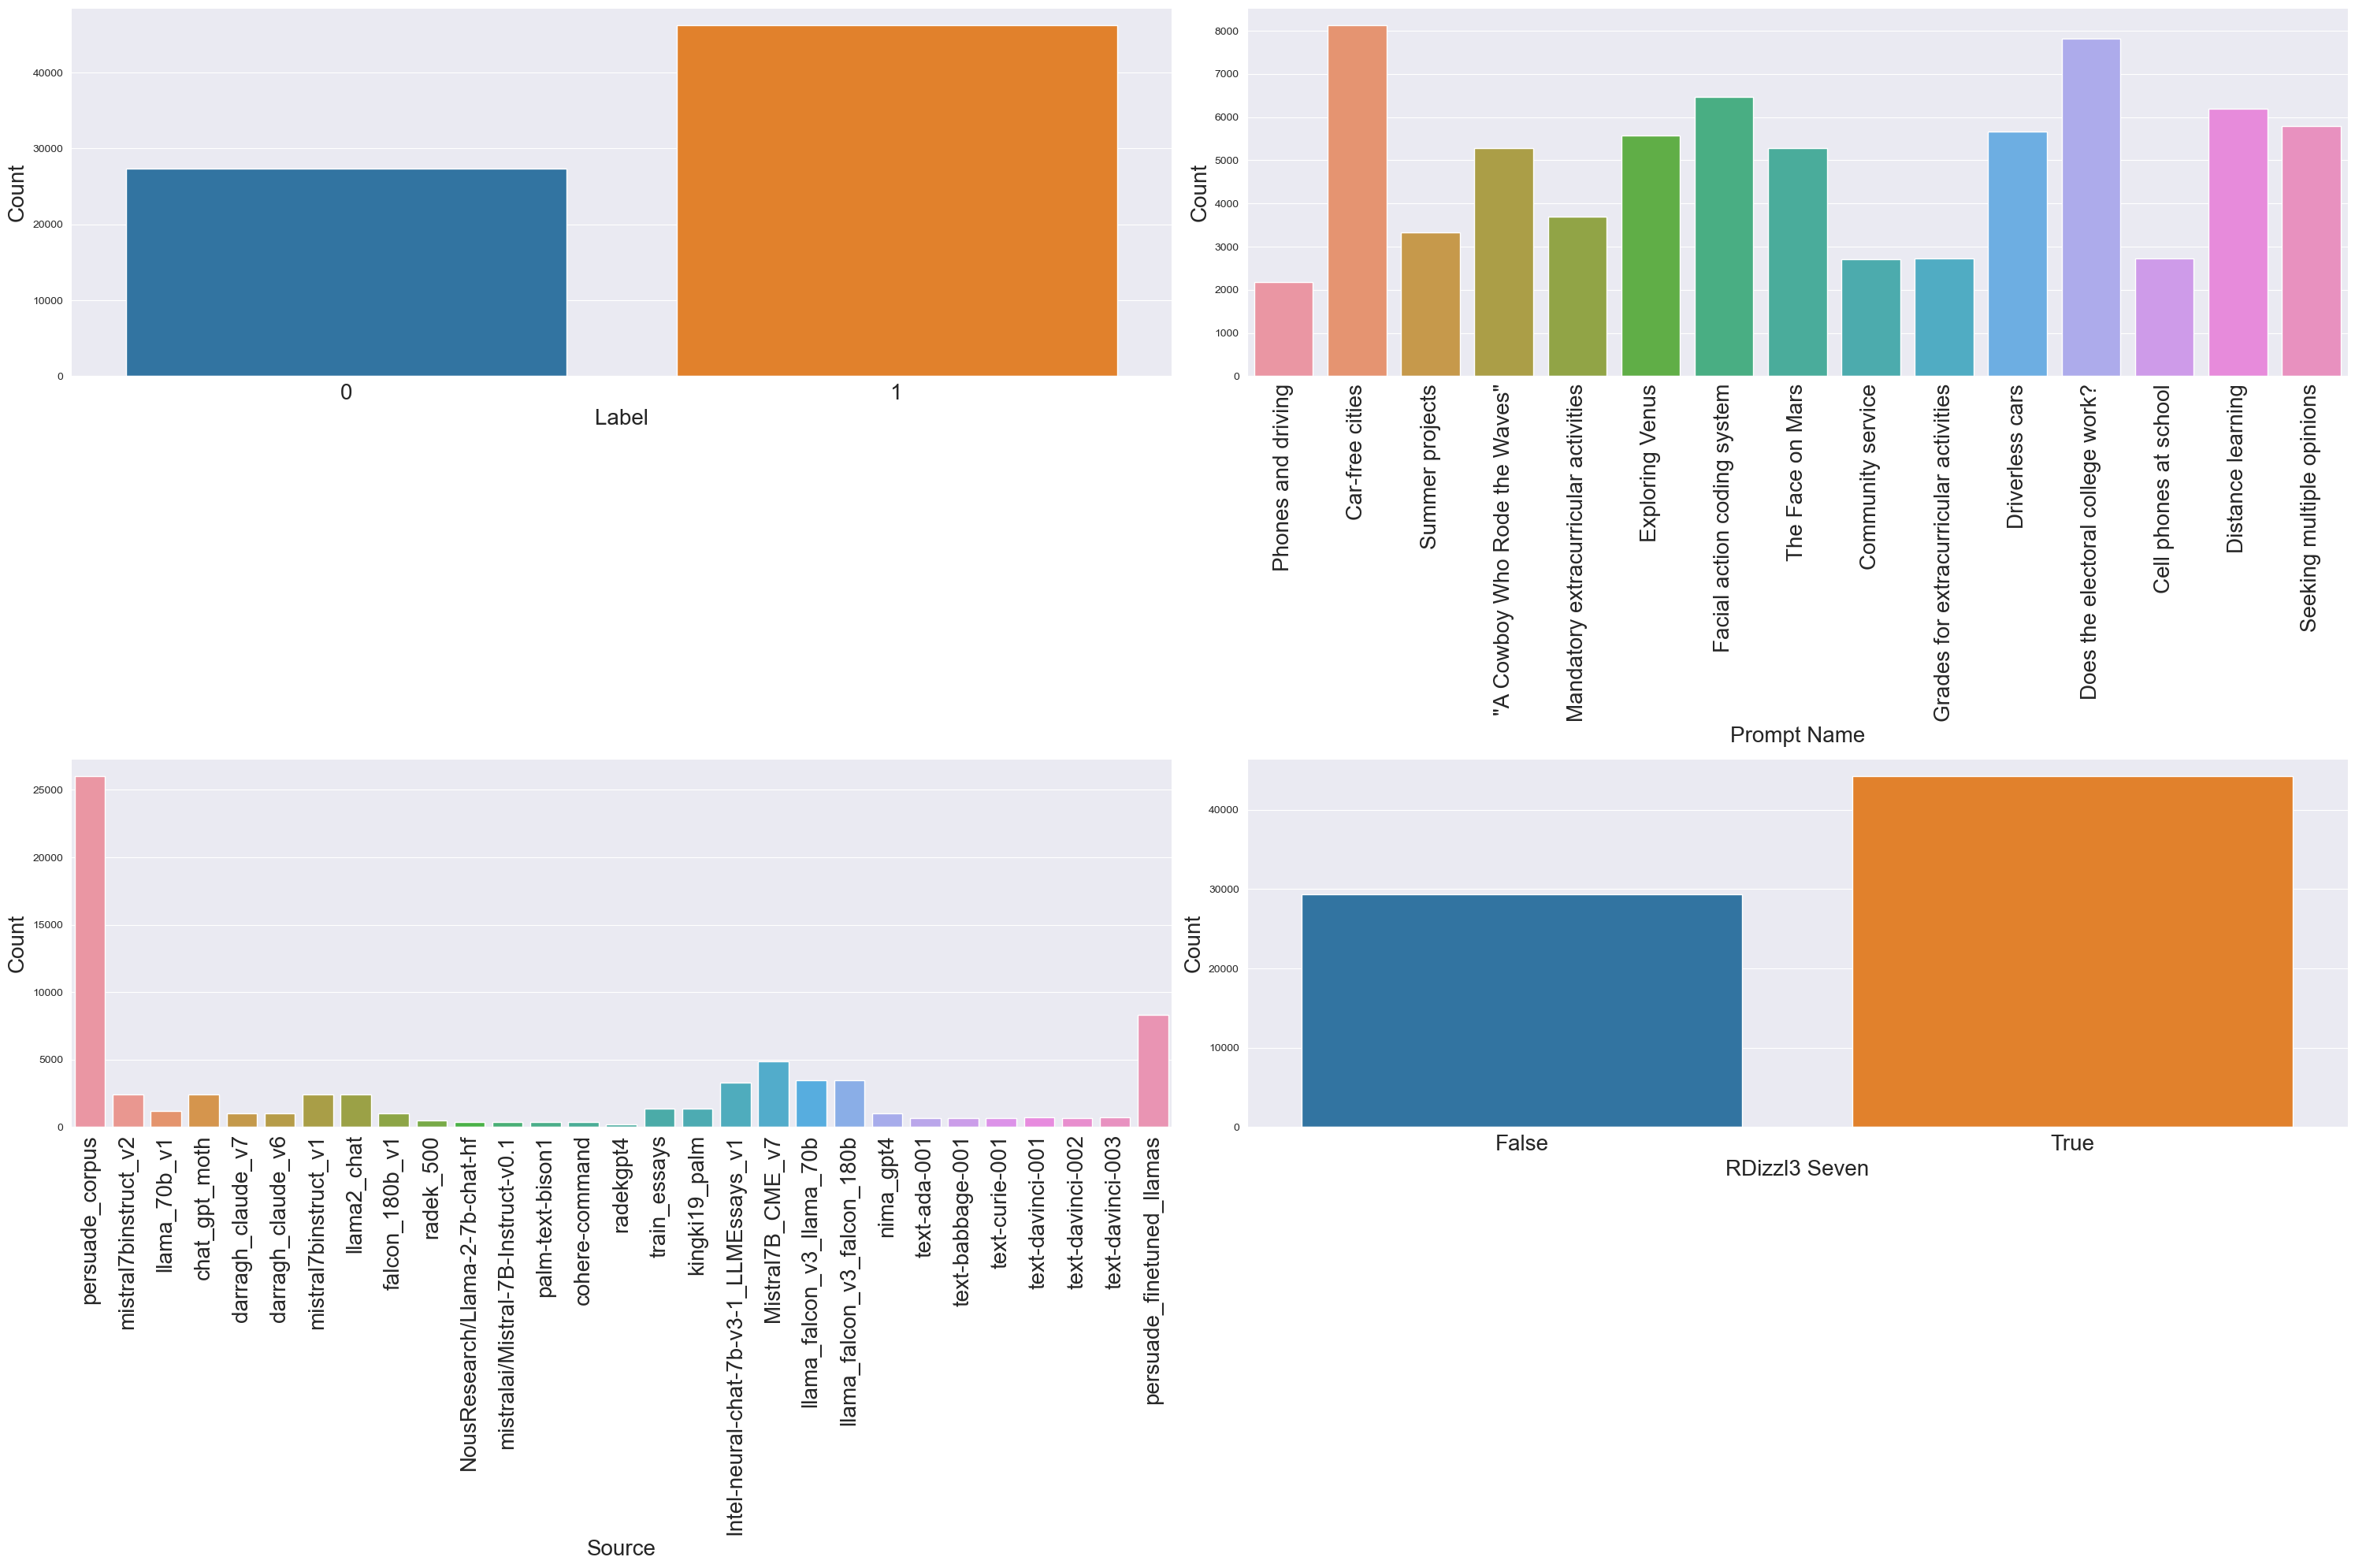

In [6]:
# Check for unique values in each column
fig, ax = plt.subplots(2, 2, figsize=(30, 20))

sns.countplot(x='label', data=df, ax=ax[0, 0])
ax[0, 0].tick_params(axis='x', labelsize=20)
ax[0, 0].set_xlabel('Label', fontsize=20)
ax[0, 0].set_ylabel('Count', fontsize=20)

sns.countplot(x='prompt_name', data=df, ax=ax[0, 1])
ax[0, 1].tick_params(axis='x', rotation=90, labelsize=20)
ax[0, 1].set_xlabel('Prompt Name', fontsize=20)
ax[0, 1].set_ylabel('Count', fontsize=20)

sns.countplot(x='source', data=df, ax=ax[1, 0])
ax[1, 0].tick_params(axis='x', rotation=90, labelsize=20)
ax[1, 0].set_xlabel('Source', fontsize=20)
ax[1, 0].set_ylabel('Count', fontsize=20)

sns.countplot(x='RDizzl3_seven', data=df, ax=ax[1, 1])
ax[1, 1].tick_params(axis='x', labelsize=20)
ax[1, 1].set_xlabel('RDizzl3 Seven', fontsize=20)
ax[1, 1].set_ylabel('Count', fontsize=20)

plt.tight_layout()
plt.show()

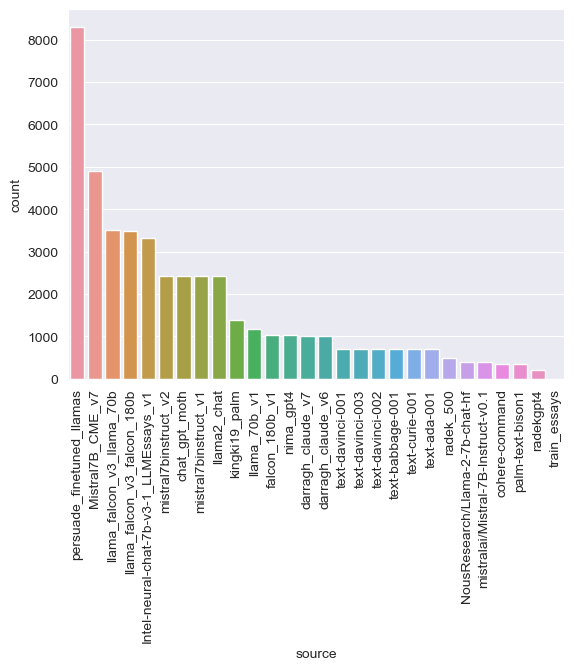

In [7]:
# Check distribution of the Source column for AI generated
subset = df[df['label'] == 1]
sns.countplot(x='source', data=subset, order=subset['source'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

- persuade fine-tuned llamas: 出現最多，約 8000 次。
- mistral7b/instruct_v2: 約5000次。
- 與其他剩餘模型: 在 4000 次以下。

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 2: Data Preprocessing 資料前處理</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Split the data into training and testing 分割資料集為訓練集和測試集</div>

In [8]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

train_df.shape, val_df.shape

((66215, 6), (7358, 6))

我們可以看到訓練集有 40381 行，驗證集有 4487 行。

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Check split distribution 檢查分割分佈</div>

In [9]:
train_df['label'].value_counts(normalize=True)

1    0.62809
0    0.37191
Name: label, dtype: float64

In [10]:
val_df['label'].value_counts(normalize=True)

1    0.627073
0    0.372927
Name: label, dtype: float64

可以看到訓練集和驗證集中 AI 生成和人類撰寫的文章比例相似。

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Create Hugging Face Datasets 創建 Hugging Face 資料集</div>

In [11]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [12]:
train_dataset

Dataset({
    features: ['text', 'label', 'prompt_name', 'source', 'RDizzl3_seven', 'model', '__index_level_0__'],
    num_rows: 66215
})

In [13]:
val_dataset

Dataset({
    features: ['text', 'label', 'prompt_name', 'source', 'RDizzl3_seven', 'model', '__index_level_0__'],
    num_rows: 7358
})

In [14]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'prompt_name': Value(dtype='string', id=None),
 'source': Value(dtype='string', id=None),
 'RDizzl3_seven': Value(dtype='bool', id=None),
 'model': Value(dtype='string', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [15]:
val_dataset.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'prompt_name': Value(dtype='string', id=None),
 'source': Value(dtype='string', id=None),
 'RDizzl3_seven': Value(dtype='bool', id=None),
 'model': Value(dtype='string', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 3: Save the datasets 儲存資料集</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Save the datasets to disk 儲存資料集到磁碟</div>

In [16]:
train_dataset.save_to_disk('data/train_dataset')
val_dataset.save_to_disk('data/val_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/66215 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7358 [00:00<?, ? examples/s]

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the datasets from disk 從磁碟載入資料集</div>

In [17]:
train_dataset = Dataset.load_from_disk('data/train_dataset')
val_dataset = Dataset.load_from_disk('data/val_dataset')

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 4: Load the transformer model 載入 Transformer 模型</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Select the model 選擇模型</div>

### Roberta

在這個 notebook 中，我們將使用 Hugging Face Roberta 模型進行文本分類任務。

- 模型名稱: `roberta-base`
- 模型類型: Transformer
- 模型架構: RoBERTa (Robustly optimized BERT approach)

In [25]:
model_name = 'roberta-base'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 5: Encode the text data 編碼文本數據</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Use the tokenizer to encode the text data 使用 tokenizer 編碼文本數據</div>

In [26]:
def encode(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

# Encode the text data
train_dataset = train_dataset.map(encode, batched=True)
val_dataset = val_dataset.map(encode, batched=True)

# Set the format to PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/66215 [00:00<?, ? examples/s]

Map:   0%|          | 0/7358 [00:00<?, ? examples/s]

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 6: Set up the training parameters and train the model 設置訓練參數並訓練模型</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Set up device 設置設備</div>

In [27]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [28]:
device

device(type='cuda')

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Set up the training parameters 設置訓練參數</div>

In [29]:
# Set up the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=24,
    per_device_eval_batch_size=24,
    warmup_steps=500,
    weight_decay=0.1,
    learning_rate=2e-5,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch'
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Start training 開始訓練</div>

In [30]:
# 禁用 WandB
os.environ["WANDB_DISABLED"] = "true"

# Start training
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.016700,0.039117
2,0.005900,0.054822
3,0.000100,0.046037


TrainOutput(global_step=8277, training_loss=0.033252874036556745, metrics={'train_runtime': 4959.1554, 'train_samples_per_second': 40.056, 'train_steps_per_second': 1.669, 'total_flos': 5.22656955919872e+16, 'train_loss': 0.033252874036556745, 'epoch': 3.0})

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 6: Evaluate the model 評估模型</div>

In [31]:
# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 0.04603694751858711, 'eval_runtime': 60.0142, 'eval_samples_per_second': 122.604, 'eval_steps_per_second': 5.115, 'epoch': 3.0}


In [32]:
eval_results

{'eval_loss': 0.04603694751858711,
 'eval_runtime': 60.0142,
 'eval_samples_per_second': 122.604,
 'eval_steps_per_second': 5.115,
 'epoch': 3.0}

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 7: Show TensorBoard logs 顯示 TensorBoard 日誌</div>

In [33]:
!tensorboard --logdir ./logs

^C


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 8: Save the model 儲存模型</div>

In [34]:
model.save_pretrained('models/roberta-base-daigt')

In [35]:
tokenizer.save_pretrained('models/roberta-base-daigt')

('models/roberta-base-daigt\\tokenizer_config.json',
 'models/roberta-base-daigt\\special_tokens_map.json',
 'models/roberta-base-daigt\\vocab.json',
 'models/roberta-base-daigt\\merges.txt',
 'models/roberta-base-daigt\\added_tokens.json',
 'models/roberta-base-daigt\\tokenizer.json')

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 9: Load the model and test 載入模型並測試</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the model and tokenizer 載入模型和 tokenizer</div>

In [36]:
model = AutoModelForSequenceClassification.from_pretrained('models/roberta-base-daigt')
tokenizer = AutoTokenizer.from_pretrained('models/roberta-base-daigt')

In [37]:
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [38]:
tokenizer

RobertaTokenizerFast(name_or_path='models/roberta-base-daigt', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Test the model 測試模型</div>

In [39]:
# Set up the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=24,
    per_device_eval_batch_size=24,
    warmup_steps=500,
    weight_decay=0.1,
    learning_rate=2e-5,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch'
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [40]:
# Predict on the validation dataset
predictions = trainer.predict(val_dataset)

In [41]:
# Get the predicted labels and the true labels
labels = predictions.label_ids
preds = predictions.predictions.argmax(-1)

# Calculate the confusion matrix
cm = confusion_matrix(labels, preds)

cm

array([[2706,   38],
       [  11, 4603]], dtype=int64)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the confusion matrix 繪製混淆矩陣</div>

<Figure size 1000x700 with 0 Axes>

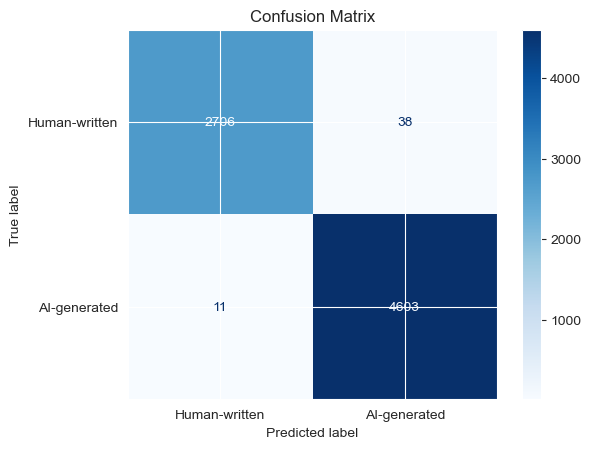

In [42]:
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human-written', 'AI-generated'])
cm_display.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Calculate the 4 scores 計算 4 個分數</div>

In [43]:
# Calculate the accuracy, precision, recall, and F1 score
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)

In [44]:
# Show the scores
pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy, precision, recall, f1]
})

,Metric,Score
0,Accuracy,0.993341
1,Precision,0.991812
2,Recall,0.997616
3,F1 Score,0.994706


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 10: Show the validation texts error 顯示驗證集錯誤文本</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Get the validation texts 獲取驗證集文本</div>

In [45]:
# Get the validation texts
val_texts = val_df['text'].tolist()
errors = [(val_texts[i], labels[i], preds[i]) for i in range(len(labels)) if labels[i] != preds[i]]

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Show the validation texts errors 顯示驗證集文本錯誤</div>

In [46]:
error_df = pd.DataFrame(errors, columns=['Text', 'True Label', 'Predicted Label'])
error_df

,Text,True Label,Predicted Label
0,"Dear Principal,\n\nI think you should use Poli...",0,1
1,Do you think summer projects should be teacher...,0,1
2,Limiting the usage of cars has a varirty of ad...,0,1
3,Are driverless cars a good idea? Are these car...,0,1
4,"Dear Mr. Principal,\n\nI have heard of your po...",0,1
5,Driverless Cars are a major form of transporta...,0,1
6,A Cowboy Who Rode the Waves tells the story of...,1,0
7,"Students want to enjoy their summer break, but...",0,1
8,To the principal:\n\nI do not agree with the p...,0,1
9,Driverless cars have been imagined and desired...,0,1


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Show the validation texts AI generated but predicted as human-written 顯示驗證集文本 AI 生成但預測為人類撰寫</div>

In [47]:
# Show the validation texts where the true label is AI generated but predicted as human-written
error_df[(error_df['True Label'] == 1) & (error_df['Predicted Label'] == 0)]

,Text,True Label,Predicted Label
6,A Cowboy Who Rode the Waves tells the story of...,1,0
10,"Dear Principal,\n\nMy name is\nI think that wa...",1,0
15,Helping someone identify their land. When you ...,1,0
23,To many that think summer breaks should be all...,1,0
28,It would be really cool if you can check out m...,1,0
31,"Dear TEACHER_NAME,\n\nI don't want students to...",1,0
33,I disagree with the moves to change to electio...,1,0
37,Hello I think this technology could be very va...,1,0
38,Thank you for giving students the opportunity ...,1,0
39,Many years of time he would sit and tell to me...,1,0


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Show the validation texts human-written but predicted as AI generated 顯示驗證集文本人類撰寫但預測為 AI 生成</div>

In [48]:
# Show the validation texts where the true label is human-written but predicted as AI generated
error_df[(error_df['True Label'] == 0) & (error_df['Predicted Label'] == 1)]

,Text,True Label,Predicted Label
0,"Dear Principal,\n\nI think you should use Poli...",0,1
1,Do you think summer projects should be teacher...,0,1
2,Limiting the usage of cars has a varirty of ad...,0,1
3,Are driverless cars a good idea? Are these car...,0,1
4,"Dear Mr. Principal,\n\nI have heard of your po...",0,1
5,Driverless Cars are a major form of transporta...,0,1
7,"Students want to enjoy their summer break, but...",0,1
8,To the principal:\n\nI do not agree with the p...,0,1
9,Driverless cars have been imagined and desired...,0,1
11,"Imagine for a minute that you are at school, o...",0,1


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Save the error DataFrame for future analysis 儲存錯誤 DataFrame 以供未來分析</div>

In [49]:
error_df.to_csv('data/error_df.csv', index=False)